In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import scipy.stats as stats

In [2]:
car_data = pd.read_csv("car_data_med1.csv")
car_data.head(3)

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0


In [3]:
print("Shape :",car_data.shape)

Shape : (8128, 13)


In [4]:
import datetime
current_year = datetime.datetime.now().year
car_data['age'] = car_data['year'].apply(lambda x : current_year - x)

In [5]:
car_basic_data = car_data.drop(columns=['name','year'])
car_basic_data.head(3)

,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,age
0,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0,8
1,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0,8
2,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0,16


### Data Preprocessing

In [6]:
print("Features with Null Values")
pd.DataFrame({"count":car_basic_data.isnull().sum()[car_basic_data.isnull().sum() > 0]
              , "proportion %":np.round(
                  car_basic_data.isnull().sum()[car_basic_data.isnull().sum() > 0] * 100 / car_basic_data.shape[0]
                  ,2)
                  })

Features with Null Values


,count,proportion %
mileage,221,2.72
engine,221,2.72
max_power,215,2.65
torque,222,2.73
seats,221,2.72


In [7]:
#Categorical Columns
cat_cols = ['fuel', 'seller_type', 'transmission', 'owner']
for col in cat_cols:
    print(f"============= {col} =============")
    print(car_basic_data[col].unique())
    print()

============= fuel =============
['Diesel' 'Petrol' 'LPG' 'CNG']

============= seller_type =============
['Individual' 'Dealer' 'Trustmark Dealer']

============= transmission =============
['Manual' 'Automatic']

============= owner =============
['First Owner' 'Second Owner' 'Third Owner' 'Fourth & Above Owner'
 'Test Drive Car']



In [8]:
car_basic_data = pd.get_dummies(car_basic_data, columns=cat_cols, drop_first=True)
car_basic_data.head(2)

,selling_price,km_driven,mileage,engine,max_power,torque,seats,age,fuel_Diesel,fuel_LPG,fuel_Petrol,seller_type_Individual,seller_type_Trustmark Dealer,transmission_Manual,owner_Fourth & Above Owner,owner_Second Owner,owner_Test Drive Car,owner_Third Owner
0,450000,145500,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0,8,1,0,0,1,0,1,0,0,0,0
1,370000,120000,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0,8,1,0,0,1,0,1,0,1,0,0


#### Checking if columns are properly formatted in their naming units

In [9]:
#Saparating numerical values from stirng features
def print_abnormal_naming(col_df):
    abnormals = set()
    for elem in col_df:
        try:
            val = elem.split()[1]
        except:
            abnormals.add(elem)
    print(f"=============== {col_df.name} ===============")
    print(abnormals)
    print()

In [10]:
print_abnormal_naming(car_basic_data['mileage'])
print_abnormal_naming(car_basic_data['engine'])
print_abnormal_naming(car_basic_data['max_power'])

=============== mileage ===============
{nan}

=============== engine ===============
{nan}

=============== max_power ===============
{nan, ' bhp', '0'}



#### Dropping max_power and torque
So for now we'll drop ```max_power``` and ```torque``` for now to keep model simple and will come back for them later.

In [11]:
car_basic_data.drop(columns=['max_power', 'torque'], inplace=True)
car_basic_data.head(2)

,selling_price,km_driven,mileage,engine,seats,age,fuel_Diesel,fuel_LPG,fuel_Petrol,seller_type_Individual,seller_type_Trustmark Dealer,transmission_Manual,owner_Fourth & Above Owner,owner_Second Owner,owner_Test Drive Car,owner_Third Owner
0,450000,145500,23.4 kmpl,1248 CC,5.0,8,1,0,0,1,0,1,0,0,0,0
1,370000,120000,21.14 kmpl,1498 CC,5.0,8,1,0,0,1,0,1,0,1,0,0


#### Converting mileage and engine to numerical data
Now we can replace values in ```mileage``` and ```engine``` with their respective numerical values by removing their units.

In [12]:
def remove_units_from_feature(col_df):
    return col_df.apply(lambda x: float(str(x).split()[0]) if x and str(x).lower() != 'none' else None)

In [13]:
car_basic_data['mileage'] = remove_units_from_feature(car_basic_data['mileage'])
car_basic_data['engine'] = remove_units_from_feature(car_basic_data['engine'])
car_basic_data.head(2)

,selling_price,km_driven,mileage,engine,seats,age,fuel_Diesel,fuel_LPG,fuel_Petrol,seller_type_Individual,seller_type_Trustmark Dealer,transmission_Manual,owner_Fourth & Above Owner,owner_Second Owner,owner_Test Drive Car,owner_Third Owner
0,450000,145500,23.40,1248.0,5.0,8,1,0,0,1,0,1,0,0,0,0
1,370000,120000,21.14,1498.0,5.0,8,1,0,0,1,0,1,0,1,0,0


### Outlier Analysis

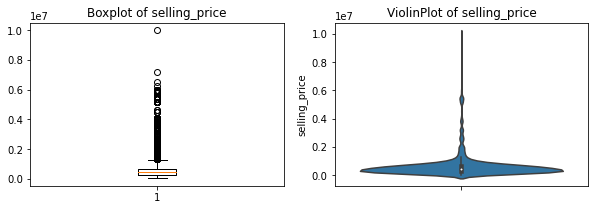

In [14]:
fig, axs = plt.subplots(1,2, figsize=(10,3))
axs[0].boxplot(car_basic_data['selling_price'])
axs[0].set_title("Boxplot of selling_price")

sns.violinplot(y='selling_price', data=car_basic_data,ax=axs[1])
axs[1].set_title("ViolinPlot of selling_price")
plt.show()

In [15]:
from scipy.stats import zscore
car_basic_data['selling_price_zscore'] = zscore(car_basic_data['selling_price'])  
car_data[(car_basic_data['selling_price_zscore'] > 3) | (car_basic_data['selling_price_zscore'] < -3)]

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,age
131,Audi Q5 35TDI Premium Plus,2018,3975000,31800,Diesel,Dealer,Automatic,First Owner,17.01 kmpl,1968 CC,188 bhp,400nm@ 1750-3000rpm,5.0,4
132,Lexus ES 300h,2019,5150000,20000,Petrol,Dealer,Automatic,First Owner,22.37 kmpl,2487 CC,214.56 bhp,202Nm@ 3600-5200rpm,5.0,3
133,Jaguar XF 2.0 Diesel Portfolio,2017,3200000,45000,Diesel,Dealer,Automatic,First Owner,19.33 kmpl,1999 CC,177 bhp,430Nm@ 1750-2500rpm,5.0,5
134,Jeep Wrangler 2016-2019 3.6 4X4,2017,4100000,17000,Petrol,Individual,Automatic,First Owner,9.5 kmpl,3604 CC,280 bhp,347Nm@ 4300rpm,5.0,5
135,Land Rover Discovery Sport TD4 SE,2019,4500000,21000,Diesel,Dealer,Automatic,First Owner,12.83 kmpl,1999 CC,148.31 bhp,382nm@ 1750-2250rpm,7.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7860,Jaguar XF 2.0 Diesel Portfolio,2017,3200000,45000,Diesel,Dealer,Automatic,First Owner,19.33 kmpl,1999 CC,177 bhp,430Nm@ 1750-2500rpm,5.0,5
7862,Volvo XC40 D4 Inscription BSIV,2019,3800000,20000,Diesel,Individual,Automatic,First Owner,18.0 kmpl,1969 CC,190 bhp,400Nm,5.0,3
7872,BMW X4 M Sport X xDrive20d,2019,5400000,7500,Diesel,Dealer,Automatic,First Owner,16.78 kmpl,1995 CC,190 bhp,400Nm@ 1750-2500rpm,5.0,3
7873,BMW X4 M Sport X xDrive20d,2019,5500000,8500,Diesel,Dealer,Automatic,First Owner,16.78 kmpl,1995 CC,190 bhp,400Nm@ 1750-2500rpm,5.0,3


We'll review ```selling_price``` outliers later since we can see some costly brand names here

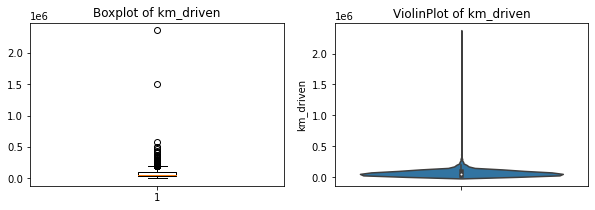

In [16]:
fig, axs = plt.subplots(1,2, figsize=(10,3))
axs[0].boxplot(car_basic_data['km_driven'])
axs[0].set_title("Boxplot of km_driven")

sns.violinplot(y='km_driven', data=car_basic_data,ax=axs[1])
axs[1].set_title("ViolinPlot of km_driven")
plt.show()

In [17]:
car_basic_data['km_driven_zscore'] = zscore(car_basic_data['km_driven'])
car_data[(car_basic_data['km_driven_zscore'] < -3) | (car_basic_data['km_driven_zscore'] > 3)]

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,age
394,Toyota Innova 2.5 G1 Diesel 8-seater,2005,250000,240000,Diesel,Individual,Manual,Third Owner,12.8 kmpl,2494 CC,102 bhp,20.4@ 1400-3400(kgm@ rpm),8.0,17
401,Tata Indigo LS,2012,95000,265000,Diesel,Individual,Manual,Second Owner,17.0 kmpl,1405 CC,70 bhp,"13.5@ 2,500(kgm@ rpm)",5.0,10
461,Toyota Innova 2.5 G (Diesel) 7 Seater,2012,730000,250000,Diesel,Individual,Manual,First Owner,12.99 kmpl,2494 CC,100 bhp,200Nm@ 1400-3400rpm,7.0,10
886,Mahindra Bolero DI Non AC BSIII,2010,320000,300000,Diesel,Individual,Manual,Third Owner,13.6 kmpl,2523 CC,63 bhp,180 Nm at 1440-1500rpm,7.0,12
998,Maruti Wagon R LXI BS IV,2012,220000,360003,Petrol,Individual,Manual,Second Owner,18.9 kmpl,998 CC,67.1 bhp,90Nm@ 3500rpm,5.0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7645,Tata Indica Vista TDI LS,2014,110000,250000,Diesel,Individual,Manual,Second Owner,19.1 kmpl,1405 CC,70 bhp,135.4Nm@ 2500rpm,5.0,8
7945,Toyota Innova 2.5 G (Diesel) 7 Seater,2012,730000,250000,Diesel,Individual,Manual,First Owner,12.99 kmpl,2494 CC,100 bhp,200Nm@ 1400-3400rpm,7.0,10
7969,Toyota Innova 2.5 G (Diesel) 7 Seater,2012,730000,250000,Diesel,Individual,Manual,First Owner,12.99 kmpl,2494 CC,100 bhp,200Nm@ 1400-3400rpm,7.0,10
8030,Tata Sumo Gold EX,2014,275000,300000,Diesel,Individual,Manual,First Owner,15.3 kmpl,2956 CC,83.83 bhp,250Nm@ 1000-2000rpm,7.0,8


Seems like some vehicles were driven over a very large distances.

### Handling NaNs

In [18]:
print("Features with Null Values")
pd.DataFrame({"count":car_basic_data.isnull().sum()[car_basic_data.isnull().sum() > 0]
              , "proportion %":np.round(
                  car_basic_data.isnull().sum()[car_basic_data.isnull().sum() > 0] * 100 / car_basic_data.shape[0]
                  ,2)
                  })

Features with Null Values


,count,proportion %
mileage,221,2.72
engine,221,2.72
seats,221,2.72


For now we'll remove Data with Null records. Later maybe we can replace them with by aggregating average *mileage* and *engine* values is already available in our dataset.

In [19]:
car_basic_data.drop(car_basic_data[car_basic_data['mileage'].isna() | car_basic_data['engine'].isna()].index, inplace=True)
print(car_basic_data.shape)

(7907, 18)


In [20]:
print("Reverifying Features with Null Values")
pd.DataFrame({"count":car_basic_data.isnull().sum()[car_basic_data.isnull().sum() > 0]
              , "proportion %":np.round(
                  car_basic_data.isnull().sum()[car_basic_data.isnull().sum() > 0] * 100 / car_basic_data.shape[0]
                  ,2)
                  })

Reverifying Features with Null Values


,count,proportion %


### Multicollinearity

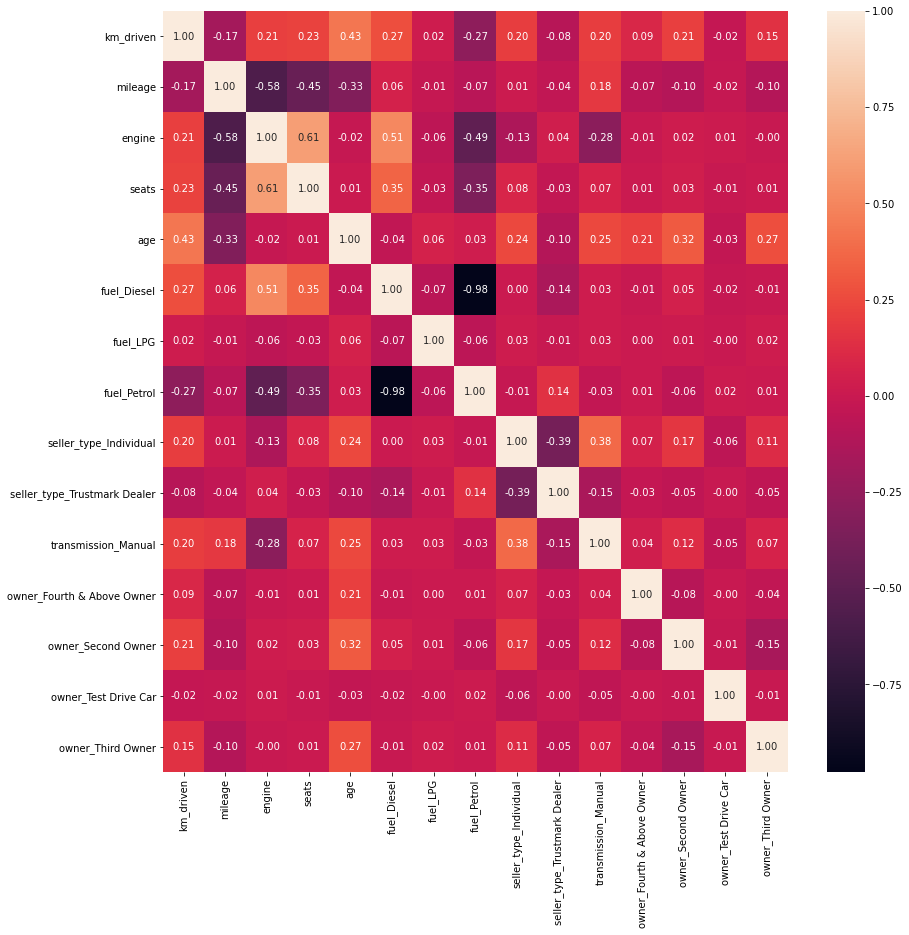

In [21]:
selected_cols = ['km_driven', 'mileage', 'engine', 'seats', 'age','fuel_Diesel', 'fuel_LPG', 'fuel_Petrol',
       'seller_type_Individual','seller_type_Trustmark Dealer', 'transmission_Manual',
        'owner_Fourth & Above Owner', 'owner_Second Owner','owner_Test Drive Car', 'owner_Third Owner']

plt.figure(figsize=(14,14))
sns.heatmap(car_basic_data[selected_cols].corr(), annot=True, fmt=".2f")
plt.show()

### Train test split

In [22]:
import statsmodels.api as sm 

selected_cols = ['km_driven', 'mileage', 'engine', 'seats', 'age','fuel_Diesel', 'fuel_LPG', 'fuel_Petrol',
       'seller_type_Individual','seller_type_Trustmark Dealer', 'transmission_Manual',
        'owner_Fourth & Above Owner', 'owner_Second Owner','owner_Test Drive Car', 'owner_Third Owner']

X_train, X_test, y_train, y_test = train_test_split(car_basic_data[selected_cols], car_basic_data['selling_price'], 
                                                   test_size=0.2 , random_state=42)

X_train, X_test = sm.add_constant(X_train), sm.add_constant(X_test)

print(f"Train Shapes X {X_train.shape} , y {y_train.shape}")
print(f"Test Shapes X {X_test.shape} , y {y_test.shape}")

Train Shapes X (6325, 16) , y (6325,)
Test Shapes X (1582, 16) , y (1582,)


### Baseline Model

In [23]:
model_1 = sm.OLS(y_train, X_train).fit()
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          selling_price   R-squared:                       0.586
Model:                            OLS   Adj. R-squared:                  0.585
Method:                 Least Squares   F-statistic:                     596.1
Date:                Sat, 22 Jan 2022   Prob (F-statistic):               0.00
Time:                        12:07:55   Log-Likelihood:                -92157.
No. Observations:                6325   AIC:                         1.843e+05
Df Residuals:                    6309   BIC:                         1.845e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                         1.756e+06    1.3e+05     13.491      0.000     1.5e+06    2.01e+06
km_driven                       -1.7017      0.157    -10.869      0.000      -2.009      -1.395
mileage                       3094.9558   2657.879      1.164      0.244   -2115.392    8305.303
engine                         754.2281     24.643     30.606      0.000     705.919     802.537
seats                         -1.59e+05   9423.894    -16.870      0.000   -1.77e+05   -1.41e+05
age                          -4.925e+04   2374.651    -20.740      0.000   -5.39e+04   -4.46e+04
fuel_Diesel                   7.761e+04   7.96e+04      0.975      0.330   -7.85e+04    2.34e+05
fuel_LPG                      2.045e+05   1.29e+05      1.587      0.112    -4.8e+04    4.57e+05
fuel_Petrol                  -8512.9857      8e+04     -0.106      0.915   -1.65e+05    1.48e+05
seller_type_Individual       -3.076e+05   2.08e+04    -14.811      0.000   -3.48e+05   -2.67e+05
seller_type_Trustmark Dealer -5.516e+05   4.24e+04    -13.010      0.000   -6.35e+05   -4.68e+05
transmission_Manual          -7.508e+05   2.35e+04    -31.964      0.000   -7.97e+05   -7.05e+05
owner_Fourth & Above Owner    5.333e+04   4.86e+04      1.097      0.273    -4.2e+04    1.49e+05
owner_Second Owner           -4.992e+04   1.68e+04     -2.965      0.003   -8.29e+04   -1.69e+04
owner_Test Drive Car          1.903e+06   2.58e+05      7.362      0.000     1.4e+06    2.41e+06
owner_Third Owner             2742.0219   2.87e+04      0.096      0.924   -5.35e+04     5.9e+04
==============================================================================
Omnibus:                     4421.327   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           136875.002
Skew:                           2.945   Prob(JB):                         0.00
Kurtosis:                      25.015   Cond. No.                     3.46e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.46e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Removing Insignificant Features

In [24]:
selected_cols = ['const', 'km_driven',  'engine', 'seats', 'age',
       'fuel_Diesel', 'fuel_LPG', 'seller_type_Individual',
       'seller_type_Trustmark Dealer', 'transmission_Manual',
        'owner_Second Owner',
       'owner_Test Drive Car']

model_2 = sm.OLS(y_train, X_train[selected_cols]).fit()
model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          selling_price   R-squared:                       0.586
Model:                            OLS   Adj. R-squared:                  0.585
Method:                 Least Squares   F-statistic:                     812.7
Date:                Sat, 22 Jan 2022   Prob (F-statistic):               0.00
Time:                        12:07:55   Log-Likelihood:                -92158.
No. Observations:                6325   AIC:                         1.843e+05
Df Residuals:                    6313   BIC:                         1.844e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                         1.843e+06   4.33e+04     42.562      0.000    1.76e+06    1.93e+06
km_driven                       -1.6911      0.156    -10.838      0.000      -1.997      -1.385
engine                         737.2891     20.094     36.693      0.000     697.899     776.679
seats                        -1.615e+05   9117.569    -17.714      0.000   -1.79e+05   -1.44e+05
age                          -4.983e+04   2030.004    -24.547      0.000   -5.38e+04   -4.59e+04
fuel_Diesel                   9.741e+04   1.62e+04      6.008      0.000    6.56e+04    1.29e+05
fuel_LPG                      2.099e+05   1.02e+05      2.063      0.039    1.04e+04    4.09e+05
seller_type_Individual       -3.067e+05   2.07e+04    -14.823      0.000   -3.47e+05   -2.66e+05
seller_type_Trustmark Dealer -5.493e+05   4.23e+04    -12.972      0.000   -6.32e+05   -4.66e+05
transmission_Manual          -7.486e+05   2.33e+04    -32.067      0.000   -7.94e+05   -7.03e+05
owner_Second Owner           -5.343e+04   1.59e+04     -3.371      0.001   -8.45e+04   -2.24e+04
owner_Test Drive Car          1.901e+06   2.58e+05      7.355      0.000    1.39e+06    2.41e+06
==============================================================================
Omnibus:                     4448.394   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           140986.945
Skew:                           2.964   Prob(JB):                         0.00
Kurtosis:                      25.357   Cond. No.                     3.46e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.46e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Normality of Errors

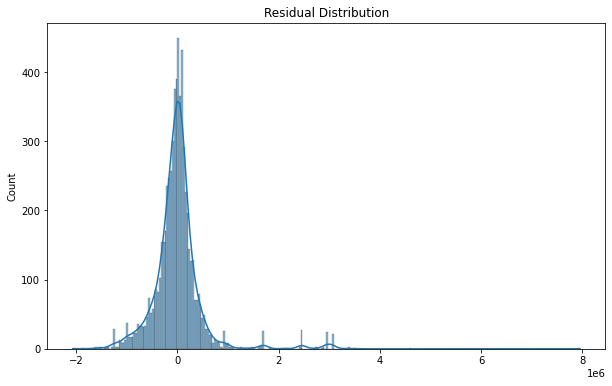

In [25]:
plt.figure(figsize=(10,6))
sns.histplot(model_2.resid, kde=True)
plt.title("Residual Distribution")
plt.show()

Residuals are normally distributed, but the distribution has fatter tail on right side indicating positive skew. Maybe this is related to the high price outliers that we observed previously

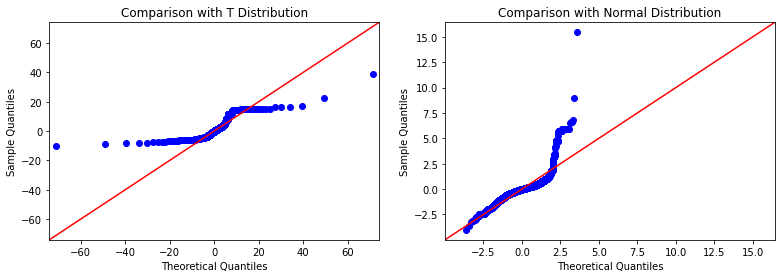

In [26]:
#probplot = sm.ProbPlot(model_2.resid)
fig, [axs1, axs2] = plt.subplots(1,2, figsize=(13, 4))
sm.qqplot(model_2.resid, stats.t, fit=True, line='45', ax=axs1)
axs1.set_title("Comparison with T Distribution")

sm.qqplot(model_2.resid, stats.norm, fit=True, line='45', ax= axs2)
axs2.set_title("Comparison with Normal Distribution")
plt.show()

#### Homoscedasticity

In [27]:
def get_standardized_values(col_df):
    return (col_df - col_df.mean())/ col_df.std()

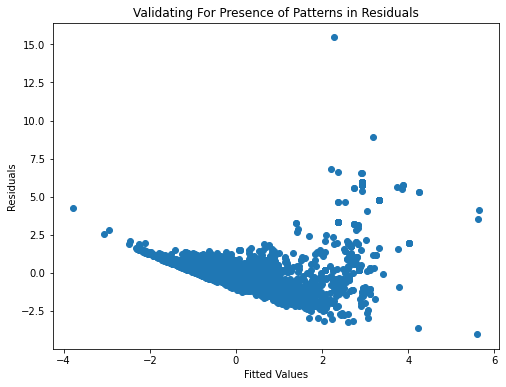

In [28]:
plt.figure(figsize=(8,6))
plt.scatter(get_standardized_values(model_2.fittedvalues), get_standardized_values(model_2.resid))
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Validating For Presence of Patterns in Residuals")
plt.show()

Points seem to be concentrated but not confidance in seeing any trend.

#### Predictions

In [29]:
y_pred = model_2.predict(X_test[selected_cols])
y_pred[:5]

3756    7.910894e+05
5691    6.202428e+05
3637    2.492002e+05
7693    4.330561e+05
3565    1.386966e+06
dtype: float64

In [30]:
scores = {}

print("RMSE: ",np.sqrt(mean_squared_error(y_pred, y_test)))
print("R-Sq: ",r2_score(y_pred, y_test))
scores['model_2'] = {
    "RMSE":np.sqrt(mean_squared_error(y_pred, y_test)) ,
    "RSq": r2_score(y_pred, y_test),
    "Remark":"Baseline model"
}

RMSE:  548044.0275010533
R-Sq:  0.2553881790365763


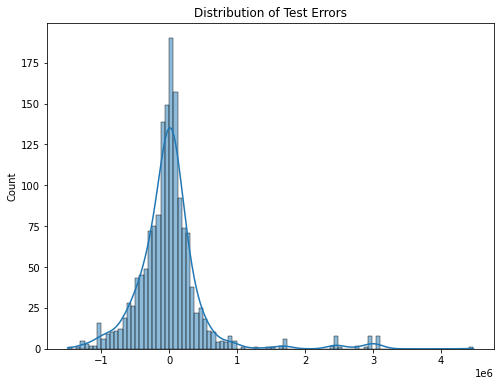

In [31]:
#Error distribution
plt.figure(figsize=(8,6))
sns.histplot((y_test - y_pred), kde=True)
plt.title("Distribution of Test Errors")
plt.show()

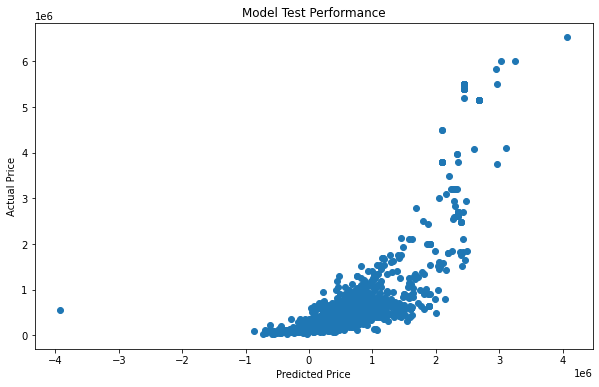

In [32]:
plt.figure(figsize=(10,6))
plt.scatter(y_pred, y_test)
plt.xlabel("Predicted Price")
plt.ylabel("Actual Price")
plt.title("Model Test Performance")
plt.show()

Text(0.5, 1.0, 'Test set Actual vs Predicted Weights ')

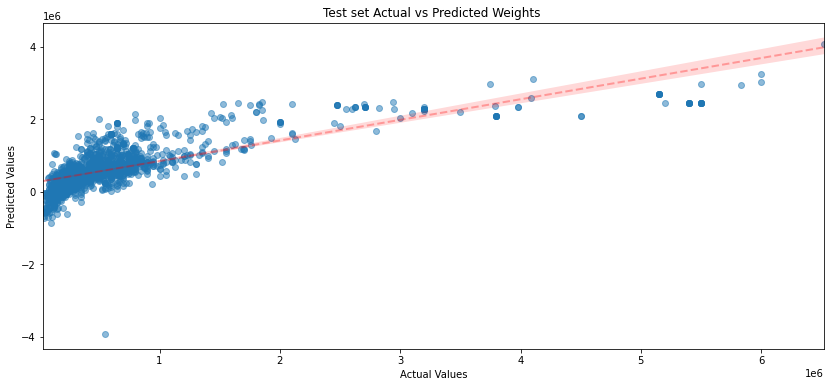

In [33]:
plt.figure(figsize=(14,6))

sns.regplot(x=y_test, y=y_pred,
           line_kws={
               'color':'r', 'alpha':0.3, 'linestyle':'--', 'linewidth':2
           },
            scatter_kws={
                'alpha':0.5
            }
           )

plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Test set Actual vs Predicted Weights ")

So baseline model tends to cause errors on lower values and bad at handelling outliers

### Tuning Model V1
#### Handeling Outliers
Currently, we'll remove outliers and handle them saparately

In [34]:
car_data_wo_outliers = car_basic_data.drop(
        car_basic_data[(car_basic_data['selling_price_zscore'] > 3) | (car_basic_data['selling_price_zscore'] < -3)
                  ].index)

car_data_wo_outliers = car_data_wo_outliers.drop(
    car_data_wo_outliers[(car_data_wo_outliers['km_driven_zscore'] < -3) | (car_data_wo_outliers['km_driven_zscore'] > 3)
                        ].index)

#### Multicollinearity

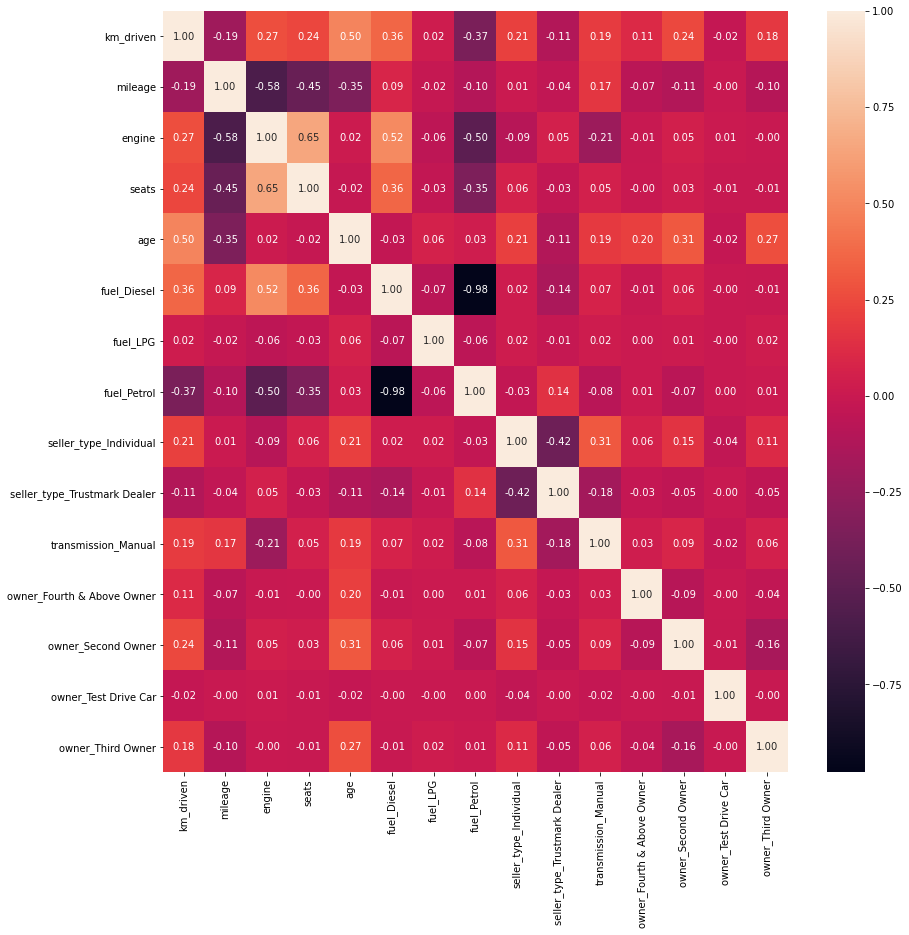

In [35]:
selected_cols = ['km_driven', 'mileage', 'engine', 'seats', 'age','fuel_Diesel', 'fuel_LPG', 'fuel_Petrol',
       'seller_type_Individual','seller_type_Trustmark Dealer', 'transmission_Manual',
        'owner_Fourth & Above Owner', 'owner_Second Owner','owner_Test Drive Car', 'owner_Third Owner']

plt.figure(figsize=(14,14))
sns.heatmap(car_data_wo_outliers[selected_cols].corr(), annot=True, fmt=".2f")
plt.show()

##### Dropping fuel_Diesel
Since ```fuel_Diesel``` is highly correlated with ```fuel_petrol```, we'll remove one of them.

In [36]:
car_data_wo_outliers.drop(columns=["fuel_Diesel"], inplace=True)

car_data_wo_outliers.head(2)

,selling_price,km_driven,mileage,engine,seats,age,fuel_LPG,fuel_Petrol,seller_type_Individual,seller_type_Trustmark Dealer,transmission_Manual,owner_Fourth & Above Owner,owner_Second Owner,owner_Test Drive Car,owner_Third Owner,selling_price_zscore,km_driven_zscore
0,450000,145500,23.40,1248.0,5.0,8,0,0,1,0,1,0,0,0,0,-0.233529,1.338363
1,370000,120000,21.14,1498.0,5.0,8,0,0,1,0,1,0,1,0,0,-0.332759,0.887411


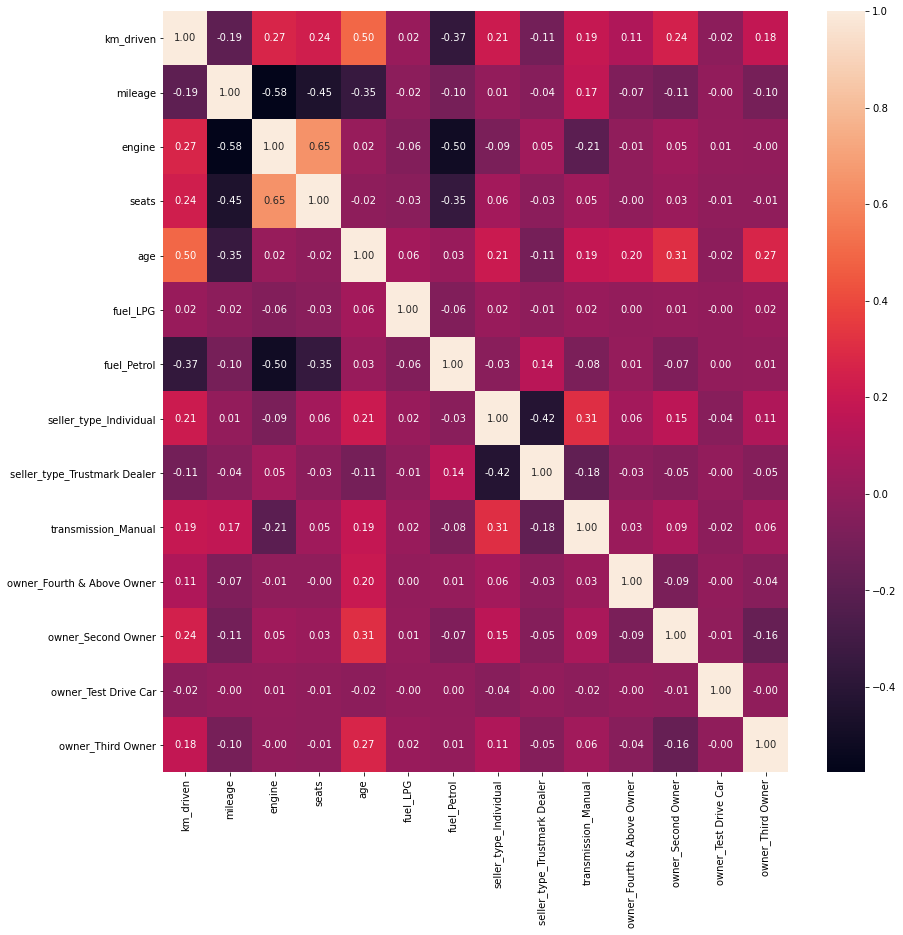

In [37]:
selected_cols = ['km_driven', 'mileage', 'engine', 'seats', 'age', 'fuel_LPG', 'fuel_Petrol',
       'seller_type_Individual','seller_type_Trustmark Dealer', 'transmission_Manual',
        'owner_Fourth & Above Owner', 'owner_Second Owner','owner_Test Drive Car', 'owner_Third Owner']

plt.figure(figsize=(14,14))
sns.heatmap(car_data_wo_outliers[selected_cols].corr(), annot=True, fmt=".2f")
plt.show()

#### Train Test Split

In [38]:
selected_cols = ['km_driven', 'mileage', 'engine', 'seats', 'age', 'fuel_LPG', 'fuel_Petrol',
       'seller_type_Individual','seller_type_Trustmark Dealer', 'transmission_Manual',
        'owner_Fourth & Above Owner', 'owner_Second Owner','owner_Test Drive Car', 'owner_Third Owner']

X_train, X_test, y_train, y_test = train_test_split(car_data_wo_outliers[selected_cols], car_data_wo_outliers['selling_price'], 
                                                   test_size=0.2 , random_state=42)

X_train, X_test = sm.add_constant(X_train), sm.add_constant(X_test)

print(f"Train Shapes X {X_train.shape} , y {y_train.shape}")
print(f"Test Shapes X {X_test.shape} , y {y_test.shape}")

Train Shapes X (6086, 15) , y (6086,)
Test Shapes X (1522, 15) , y (1522,)


#### Modelling

In [39]:
model_3 = sm.OLS(y_train, X_train).fit()
model_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          selling_price   R-squared:                       0.640
Model:                            OLS   Adj. R-squared:                  0.639
Method:                 Least Squares   F-statistic:                     770.7
Date:                Sat, 22 Jan 2022   Prob (F-statistic):               0.00
Time:                        12:07:59   Log-Likelihood:                -84424.
No. Observations:                6086   AIC:                         1.689e+05
Df Residuals:                    6071   BIC:                         1.690e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                         1.581e+06   5.72e+04     27.647      0.000    1.47e+06    1.69e+06
km_driven                       -1.5558      0.102    -15.278      0.000      -1.755      -1.356
mileage                      -1.199e+04   1425.522     -8.409      0.000   -1.48e+04   -9192.220
engine                         370.5092     13.525     27.395      0.000     343.995     397.023
seats                        -6.913e+04   4861.080    -14.222      0.000   -7.87e+04   -5.96e+04
age                          -4.169e+04   1232.218    -33.834      0.000   -4.41e+04   -3.93e+04
fuel_LPG                     -7.035e+04   5.14e+04     -1.368      0.171   -1.71e+05    3.04e+04
fuel_Petrol                  -1.592e+05   1.03e+04    -15.453      0.000   -1.79e+05   -1.39e+05
seller_type_Individual       -1.155e+05   1.07e+04    -10.795      0.000   -1.36e+05   -9.45e+04
seller_type_Trustmark Dealer -9.676e+04   2.17e+04     -4.456      0.000   -1.39e+05   -5.42e+04
transmission_Manual          -3.776e+05   1.24e+04    -30.537      0.000   -4.02e+05   -3.53e+05
owner_Fourth & Above Owner   -1.968e+04   2.47e+04     -0.797      0.426   -6.81e+04    2.88e+04
owner_Second Owner           -4.224e+04   8444.835     -5.002      0.000   -5.88e+04   -2.57e+04
owner_Test Drive Car          4.786e+05   1.82e+05      2.637      0.008    1.23e+05    8.34e+05
owner_Third Owner            -2.858e+04   1.46e+04     -1.954      0.051   -5.72e+04      86.622
==============================================================================
Omnibus:                     2012.775   Durbin-Watson:                   2.030
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11878.318
Skew:                           1.457   Prob(JB):                         0.00
Kurtosis:                       9.193   Cond. No.                     4.43e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.43e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Removing Insignificant Features

In [40]:
selected_cols = ['const', 'km_driven', 'mileage', 'engine', 'seats', 'age', 
       'fuel_Petrol', 'seller_type_Individual', 'seller_type_Trustmark Dealer',
       'transmission_Manual', 
       'owner_Second Owner', 'owner_Test Drive Car']

model_4 = sm.OLS(y_train, X_train[selected_cols]).fit()
model_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          selling_price   R-squared:                       0.640
Model:                            OLS   Adj. R-squared:                  0.639
Method:                 Least Squares   F-statistic:                     979.9
Date:                Sat, 22 Jan 2022   Prob (F-statistic):               0.00
Time:                        12:07:59   Log-Likelihood:                -84427.
No. Observations:                6086   AIC:                         1.689e+05
Df Residuals:                    6074   BIC:                         1.690e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                         1.569e+06   5.65e+04     27.763      0.000    1.46e+06    1.68e+06
km_driven                       -1.5714      0.101    -15.486      0.000      -1.770      -1.373
mileage                       -1.16e+04   1409.439     -8.229      0.000   -1.44e+04   -8835.458
engine                         374.1760     13.347     28.034      0.000     348.010     400.342
seats                        -6.882e+04   4860.473    -14.159      0.000   -7.83e+04   -5.93e+04
age                          -4.236e+04   1178.628    -35.939      0.000   -4.47e+04      -4e+04
fuel_Petrol                  -1.564e+05   1.02e+04    -15.411      0.000   -1.76e+05   -1.37e+05
seller_type_Individual       -1.173e+05   1.07e+04    -11.006      0.000   -1.38e+05   -9.64e+04
seller_type_Trustmark Dealer -9.824e+04   2.17e+04     -4.526      0.000   -1.41e+05   -5.57e+04
transmission_Manual          -3.771e+05   1.24e+04    -30.494      0.000   -4.01e+05   -3.53e+05
owner_Second Owner           -3.668e+04   7955.133     -4.611      0.000   -5.23e+04   -2.11e+04
owner_Test Drive Car          4.762e+05   1.82e+05      2.623      0.009     1.2e+05    8.32e+05
==============================================================================
Omnibus:                     2013.532   Durbin-Watson:                   2.030
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11857.944
Skew:                           1.458   Prob(JB):                         0.00
Kurtosis:                       9.185   Cond. No.                     4.43e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.43e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Normality of Errors

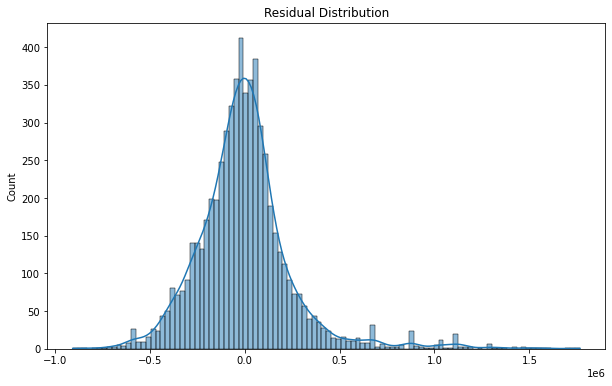

In [41]:
plt.figure(figsize=(10,6))
sns.histplot(model_4.resid, kde=True)
plt.title("Residual Distribution")
plt.show()

Now the tail for less fatter than baseline model

#### Homoscedasticity

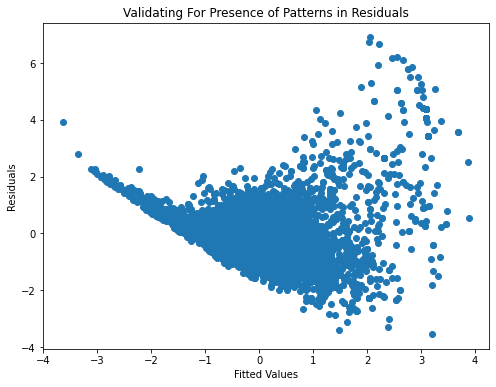

In [42]:
plt.figure(figsize=(8,6))
plt.scatter(get_standardized_values(model_4.fittedvalues), get_standardized_values(model_4.resid))
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Validating For Presence of Patterns in Residuals")
plt.show()

Errors are widely spread than before now.

#### Predictions

In [43]:
y_pred = model_4.predict(X_test[selected_cols])
y_pred[:5]

2833    1.052923e+06
2387    3.700290e+05
6094    4.977393e+05
147     6.509193e+05
3393    5.415020e+05
dtype: float64

In [44]:
print("RMSE: ",np.sqrt(mean_squared_error(y_pred, y_test)))
print("R-Sq: ",r2_score(y_pred, y_test))
scores['model_4'] = {
    "RMSE":np.sqrt(mean_squared_error(y_pred, y_test)) ,
    "RSq": r2_score(y_pred, y_test),
    "Remark":"Removed Outliers and Multicollinearity"
}

RMSE:  263547.57237008127
R-Sq:  0.42723591290816654


R-squarred also improved significantly and RMSE almost halved.

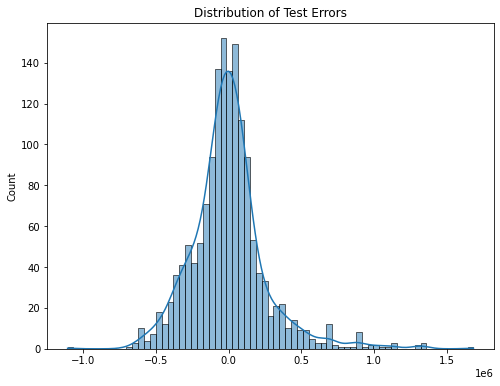

In [45]:
#Error distribution
plt.figure(figsize=(8,6))
sns.histplot((y_test - y_pred), kde=True)
plt.title("Distribution of Test Errors")
plt.show()

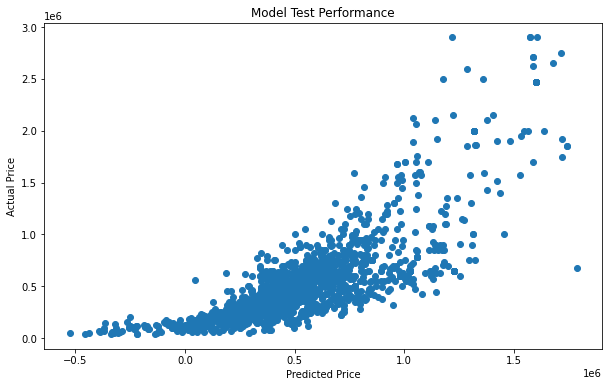

In [46]:
plt.figure(figsize=(10,6))
plt.scatter(y_pred, y_test)
plt.xlabel("Predicted Price")
plt.ylabel("Actual Price")
plt.title("Model Test Performance")
plt.show()

Text(0.5, 1.0, 'Test set Actual vs Predicted Weights ')

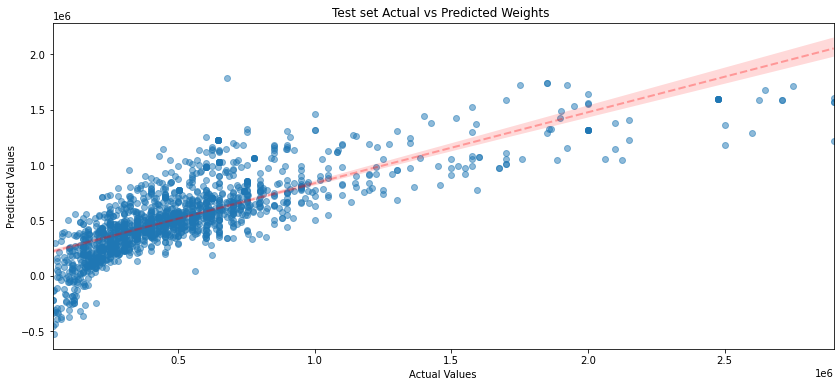

In [47]:
plt.figure(figsize=(14,6))

sns.regplot(x=y_test, y=y_pred,
           line_kws={
               'color':'r', 'alpha':0.3, 'linestyle':'--', 'linewidth':2
           },
            scatter_kws={
                'alpha':0.5
            }
           )

plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Test set Actual vs Predicted Weights ")

In [60]:
df_scores = pd.DataFrame(scores).T
df_scores['RMSE'] = df_scores['RMSE'].apply(lambda x : f"{int(x):,}")
df_scores['RSq'] = df_scores['RSq'].apply(lambda x : np.round(x, 2))
df_scores

,RMSE,RSq,Remark
model_2,"548,044",0.26,Baseline model
model_4,"263,547",0.43,Removed Outliers and Multicollinearity


So model has improved significantly that baseline model, but there are still some car prices getting predicted as negatives,and also model tends to underestimate higher prices.

### XGBoost

In [81]:
X_train_grad = X_train[selected_cols]
X_train_grad.drop(columns=["const"], inplace=True)
X_train_grad.head(4)

C:\Users\mruty\anaconda3\envs\opencv\lib\site-packages\pandas\core\frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,km_driven,mileage,engine,seats,age,fuel_Petrol,seller_type_Individual,seller_type_Trustmark Dealer,transmission_Manual,owner_Second Owner,owner_Test Drive Car
1751,70000,24.52,1248.0,7.0,5,0,1,0,1,0,0
5353,60000,17.00,1198.0,5.0,6,1,1,0,1,0,0
4693,90000,18.49,1493.0,7.0,6,0,1,0,0,1,0
7988,32000,28.09,1248.0,5.0,3,0,1,0,1,0,0


In [82]:
X_test_grad = X_test[selected_cols]
X_test_grad.drop(columns=["const"], inplace=True)

C:\Users\mruty\anaconda3\envs\opencv\lib\site-packages\pandas\core\frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


#### Standard Scaling data

In [83]:
from sklearn.preprocessing import StandardScaler

scaled_cols = ['km_driven', "mileage" , "engine" , "seats" , "age"]
sc = StandardScaler()
sc.fit(X_train_grad[scaled_cols])

X_train_grad[scaled_cols] = sc.transform(X_train_grad[scaled_cols])
X_test_grad[scaled_cols] = sc.transform(X_test_grad[scaled_cols])

C:\Users\mruty\anaconda3\envs\opencv\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mruty\anaconda3\envs\opencv\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\mruty\anaconda3\envs\opencv\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

In [70]:
# Import xgboost ensemble model
import xgboost

#core import for hyperparamter tuning
from sklearn.model_selection import RandomizedSearchCV

#creates a xgbRegressor object
regressor=xgboost.XGBRegressor()

#### Modelling and Hyperparameter Tuning

In [72]:
#Hyperparamter_Tuning
n_estimators = [100, 500, 900, 1100, 1500]
max_depth = [2, 3, 5, 10, 15]
booster=['gbtree','gblinear']
learning_rate=[0.05,0.1,0.15,0.20]
min_child_weight=[1,2,3,4]
base_score=[0.25,0.5,0.75,1]

# Define the grid of hyperparameters to search
parameter_grid = {
    'n_estimators': n_estimators,
    'max_depth':max_depth,
    'learning_rate':learning_rate,
    'min_child_weight':min_child_weight,
    'booster':booster,
    'base_score':base_score
    }

In [73]:
# Set up the random search with 5-fold cross validation
random_cv = RandomizedSearchCV(estimator=regressor,
            param_distributions=parameter_grid,
            cv=5, n_iter=50,
            scoring = 'neg_mean_absolute_error',n_jobs = 3,
            verbose = 5, 
            return_train_score = True,
            random_state=42)

In [86]:
#train on the RandomSearchCv object to get best estimators
random_cv.fit(X_train_grad,y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


C:\Users\mruty\anaconda3\envs\opencv\lib\site-packages\joblib\externals\loky\process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n...
                                          validate_parameters=None,
                                          verbosity=None),
                   n_iter=50, n_jobs=3,
                   para

In [87]:
random_cv.best_estimator_

XGBRegressor(base_score=0.75, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=5,
             min_child_weight=2, missing=nan, monotone_constraints='()',
             n_estimators=1100, n_jobs=12, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [88]:
#getting the best params
random_cv.best_params_

{'n_estimators': 1100,
 'min_child_weight': 2,
 'max_depth': 5,
 'learning_rate': 0.1,
 'booster': 'gbtree',
 'base_score': 0.75}

In [92]:
# reinitializing the regressor object with the best probable estimators
regressor=xgboost.XGBRegressor(base_score=0.75, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=5,
             min_child_weight=2, missing=np.nan, monotone_constraints='()',
             n_estimators=1100, n_jobs=12, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [93]:
# fitting the xgbRegressor on our training data
regressor.fit(X_train_grad,y_train)

XGBRegressor(base_score=0.75, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=5,
             min_child_weight=2, missing=nan, monotone_constraints='()',
             n_estimators=1100, n_jobs=12, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [95]:
# fetching the predictions on our test data
y_pred_boost=regressor.predict(X_test_grad)

#### Normality of Errors

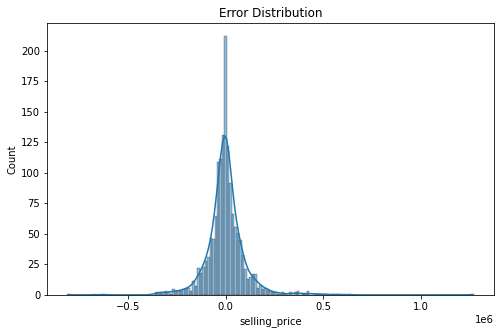

In [103]:
plt.figure(figsize=(8,5))
sns.histplot(y_test - y_pred_boost, kde=True)
plt.title("Error Distribution")
plt.show()

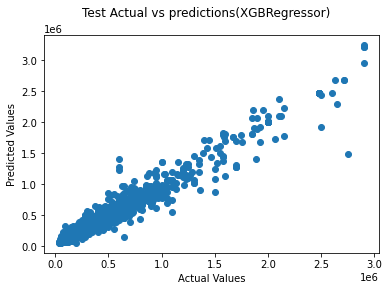

In [101]:
fig = plt.figure()
# Plot-label
fig.suptitle('Test Actual vs predictions(XGBRegressor)')

#X-label
plt.xlabel('Actual Values')

# Y-label
plt.ylabel('Predicted Values')
plt.scatter(y_test,y_pred_boost)

Text(0.5, 1.0, 'Test set Actual vs Predicted Weights ')

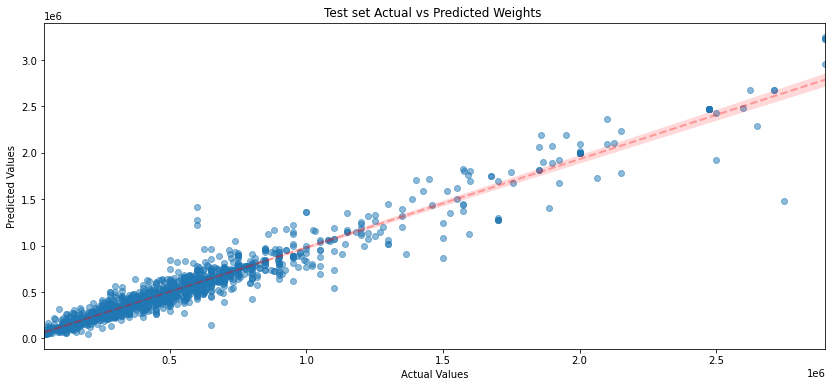

In [100]:
plt.figure(figsize=(14,6))

sns.regplot(x=y_test, y=y_pred_boost,
           line_kws={
               'color':'r', 'alpha':0.3, 'linestyle':'--', 'linewidth':2
           },
            scatter_kws={
                'alpha':0.5
            }
           )

plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Test set Actual vs Predicted Weights ")

In [97]:
print("RMSE: ",np.sqrt(mean_squared_error(y_pred_boost, y_test)))
print("R-Sq: ",r2_score(y_pred_boost, y_test))
scores['model_xgboost'] = {
    "RMSE":np.sqrt(mean_squared_error(y_pred_boost, y_test)) ,
    "RSq": r2_score(y_pred_boost, y_test),
    "Remark":"After XGBoost"
}

RMSE:  106553.76512193661
R-Sq:  0.9360741565264066


In [99]:
pd.DataFrame(scores).T

,RMSE,RSq,Remark
model_2,548044.027501,0.255388,Baseline model
model_4,263547.57237,0.427236,Removed Outliers and Multicollinearity
model_xgboost,106553.765122,0.936074,After XGBoost


With more flexible model, we were able to again significantly increase our model performance

In [120]:
y_pred.min(), y_pred_boost.min(), y_test.min()

(-526862.4650760384, 48094.004, 40000)

So like previous iterations, our model has not shown any signs of negative prices.

### TODO: Outliers Analysis